In [1]:
#import the libraries needed
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Flatten,BatchNormalization,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import binary_accuracy
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import skimage
import os
import cv2
import imageio
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# Data Preparation

In [2]:
shen_image = os.listdir('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Shenzen')
mont_image = os.listdir('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Montgomery')

In [3]:
# Function to select the 4th index from the end of the string (file name)
# example: CHNCXR_0470_1.png --> 1 is the label, meaning TB is present.

def extract_target(x):
    target = int(x[-5])
    if target == 0:
        return 'Normal'
    if target == 1:
        return 'Tuberculosis'

In [4]:
import pandas as pd
# put the images into dataframes
df_shen = pd.DataFrame(shen_image, columns=['image_id'])
df_mont = pd.DataFrame(mont_image, columns=['image_id'])

In [5]:
print(df_shen.shape)
print(df_mont.shape)

(662, 1)
(138, 1)


In [6]:
# Assign the target labels

df_shen['target'] = df_shen['image_id'].apply(extract_target)

df_mont['target'] = df_mont['image_id'].apply(extract_target)

In [7]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['image_id']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()

In [8]:
# Shenzen Dataset

df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

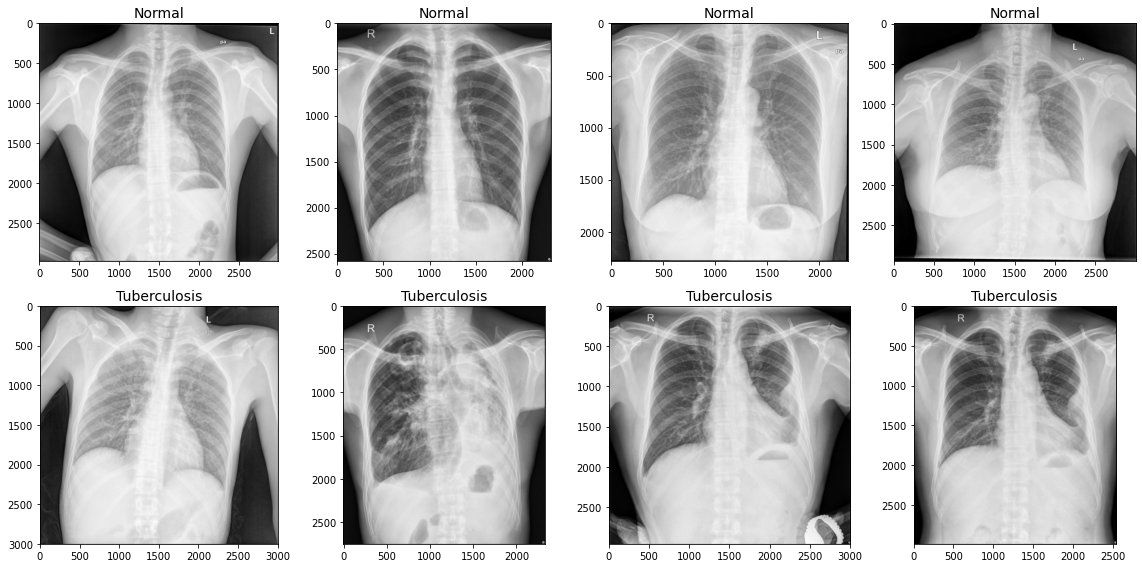

In [9]:
# Shenzen Dataset

IMAGE_PATH = 'C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Shenzen/' 

draw_category_images('target',4, df_shen, IMAGE_PATH)

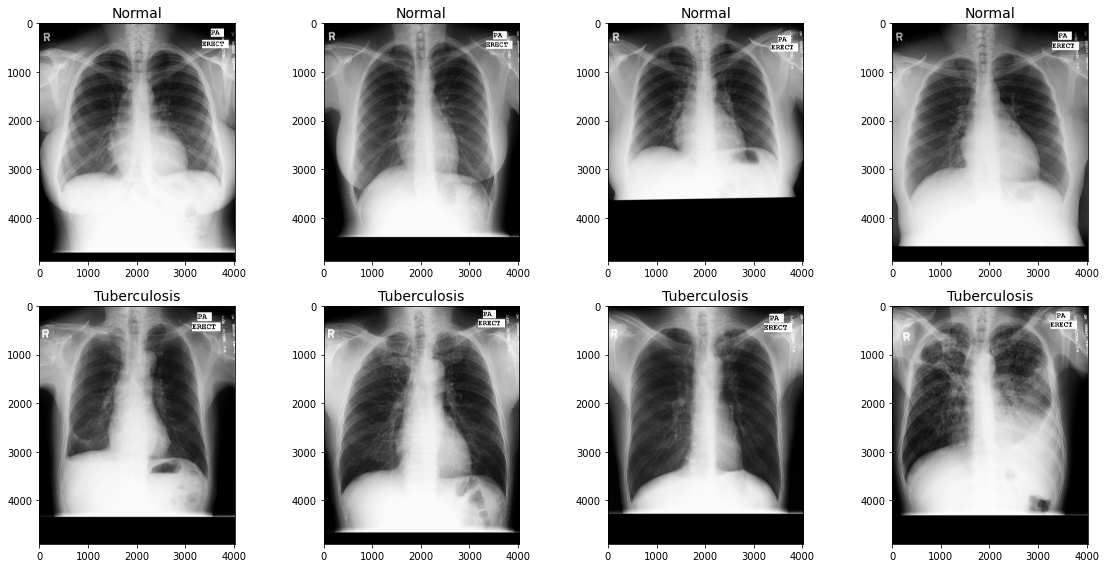

In [10]:
# Montgomery Dataset

IMAGE_PATH = 'C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Montgomery/'

draw_category_images('target',4, df_mont, IMAGE_PATH)

In [11]:
def read_image_sizes(file_name):
    """
    1. Get the shape of the image
    2. Get the min and max pixel values in the image.
    Getting pixel values will tell if any pre-processing has been done.
    3. This info will be added to the original dataframe.
    """
    image = cv2.imread(IMAGE_PATH + file_name)
    max_pixel_val = image.max()
    min_pixel_val = image.min()
    
    # image.shape[2] represents the number of channels: (height, width, num_channels).
    # Here we are saying: If the shape does not have a value for num_channels (height, width)
    # then assign 1 to the number of channels.
    if len(image.shape) > 2: # i.e. more than two numbers in the tuple
        output = [image.shape[0], image.shape[1], image.shape[2], max_pixel_val, min_pixel_val]
    else:
        output = [image.shape[0], image.shape[1], 1, max_pixel_val, min_pixel_val]
    return output

In [12]:
IMAGE_PATH = 'C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Shenzen/'

m = np.stack(df_shen['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_shen = pd.concat([df_shen,df],axis=1, sort=False)

df_shen.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,CHNCXR_0001_0.png,Normal,2919,3000,3,255,0
1,CHNCXR_0002_0.png,Normal,2951,3000,3,255,0
2,CHNCXR_0003_0.png,Normal,2945,2987,3,255,0
3,CHNCXR_0004_0.png,Normal,2933,3000,3,255,0
4,CHNCXR_0005_0.png,Normal,2933,3000,3,255,0


In [13]:
df_shen['target'].value_counts()

Tuberculosis    336
Normal          326
Name: target, dtype: int64

In [14]:
IMAGE_PATH = 'C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Montgomery/'

m = np.stack(df_mont['image_id'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','c','max_pixel_val','min_pixel_val'])
df_mont = pd.concat([df_mont,df],axis=1, sort=False)

df_mont.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val
0,MCUCXR_0001_0.png,Normal,4020,4892,3,255,0
1,MCUCXR_0002_0.png,Normal,4020,4892,3,255,0
2,MCUCXR_0003_0.png,Normal,4892,4020,3,255,0
3,MCUCXR_0004_0.png,Normal,4892,4020,3,255,0
4,MCUCXR_0005_0.png,Normal,4892,4020,3,255,0


In [15]:
df_mont['target'].value_counts()

Normal          80
Tuberculosis    58
Name: target, dtype: int64

In [16]:
### concat is combine
### Combine the two dataframes and shuffle
### reset index if dont want save as column
df_data = pd.concat([df_shen, df_mont], axis=0).reset_index(drop=True)

df_data = shuffle(df_data)


df_data.shape

(800, 7)

In [17]:
# Create a new column called 'label' that maps the classes to binary values.
# map target to label 
df_data['label'] = df_data['target'].map({'Normal':0, 'Tuberculosis':1})

In [18]:
df_data.head()

,image_id,target,w,h,c,max_pixel_val,min_pixel_val,label
786,MCUCXR_0348_1.png,Tuberculosis,4020,4892,3,255,0,1
561,CHNCXR_0562_1.png,Tuberculosis,2590,2516,3,255,0,1
451,CHNCXR_0452_1.png,Tuberculosis,2804,2423,3,255,0,1
96,CHNCXR_0097_0.png,Normal,2203,2260,3,255,0,0
351,CHNCXR_0352_1.png,Tuberculosis,2921,2573,3,255,0,1


In [19]:
# train_test_split

y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(680, 8)
(120, 8)


In [20]:
df_train['target'].value_counts()

Normal          345
Tuberculosis    335
Name: target, dtype: int64

In [21]:
df_val['target'].value_counts()

Normal          61
Tuberculosis    59
Name: target, dtype: int64

Create Directories

In [22]:
#Create new directory
base_dir='TB_directoriesVGG19_feature_extract(try)'
os.mkdir(base_dir)

#Create train and validation folders
train_dir=os.path.join(base_dir,'train_dir')
os.mkdir(train_dir)

val_dir=os.path.join(base_dir,'val_dir')
os.mkdir(val_dir)

#Create new folder inside train_dir
Normal=os.path.join(train_dir,'Normal')
os.mkdir(Normal)
Tuberculosis=os.path.join(train_dir,'Tuberculosis')
os.mkdir(Tuberculosis)

#Create new folder inside val_dir
Normal=os.path.join(val_dir,'Normal')
os.mkdir(Normal)
Tuberculosis=os.path.join(val_dir,'Tuberculosis')
os.mkdir(Tuberculosis)

Transfer images into the folder

In [23]:
#Set image_id as index in df_data
df_data.set_index('image_id',inplace=True)

In [24]:
#Set the image width and height 
IMAGE_WIDTH=224
IMAGE_HEIGHT=224

#Get images in each two folder
folder_shen=os.listdir('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Shenzen')
folder_mont=os.listdir('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Montgomery')

#Get list of train and val image
train_list=list(df_train['image_id'])
val_list=list(df_val['image_id'])

#Transfer the train images

for image in train_list:
    fname=image
    label=df_data.loc[image,'target']
    
    if fname in folder_shen:
        #source path to image
        src=os.path.join('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Shenzen',fname)
        #destination path to image
        dest=os.path.join(train_dir, label,fname)
        
        image=cv2.imread(src)
        image=cv2.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH))
        
        #save the image at destination
        cv2.imwrite(dest,image)
        
    if fname in folder_mont:
        #source path to image
        src=os.path.join('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Montgomery',fname)
        #destination path to image
        dest=os.path.join(train_dir, label,fname)
        
        image=cv2.imread(src)
        image=cv2.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH))
        
        #save the image at destination
        cv2.imwrite(dest,image)
        
#Transfer the val images

for image in val_list:
    fname=image
    label=df_data.loc[image,'target']
    
    if fname in folder_shen:
        #source path to image
        src=os.path.join('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Shenzen',fname)
        #destination path to image
        dest=os.path.join(val_dir, label,fname)
        
        image=cv2.imread(src)
        image=cv2.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH))
        
        #save the image at destination
        cv2.imwrite(dest,image)
        
    if fname in folder_mont:
        #source path to image
        src=os.path.join('C:/Users/User/Pictures/sajo try data TB/pulmonary-chest-xray-abnormalities/try/Montgomery',fname)
        #destination path to image
        dest=os.path.join(val_dir, label,fname)
        
        image=cv2.imread(src)
        image=cv2.resize(image,(IMAGE_HEIGHT,IMAGE_WIDTH))
        
        #save the image at destination
        cv2.imwrite(dest,image)

In [25]:
#Check how many images have in train folder
print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/train_dir/Normal')))
print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/train_dir/Tuberculosis')))

345
335


In [26]:
#Check how many images in val folder
print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/val_dir/Normal')))
print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/val_dir/Tuberculosis')))

61
59


In [27]:
import shutil
#Create augmented directory path
TB_list=['Normal','Tuberculosis']

for folder in TB_list:
    aug_dir='augmented_directory_vgg19_feature_extract(try)'
    os.mkdir(aug_dir)
    
    img_dir=os.path.join(aug_dir,'img_dir')
    os.mkdir(img_dir)
    
    img_class=folder
    
    #list image in that directory
    img_list=os.listdir('TB_directoriesVGG19_feature_extract(try)/train_dir/'+img_class)
    
    #Copy images from train_dir to img_dir
    for name in img_list:
        #source of image
        src=os.path.join('TB_directoriesVGG19_feature_extract(try)/train_dir/'+img_class,name)
        #destination to the image
        dest=os.path.join(img_dir,name)
        
        #Copy the image from source to destination
        shutil.copyfile(src,dest)
        
        #now define variable called gen as an ImageDataGenerator. 
        #All the parameters being passed are the different ways we’re telling Keras to augment the image.
    
    path=aug_dir
    save_path='TB_directoriesVGG19_feature_extract(try)/train_dir/' +img_class
    generator = ImageDataGenerator(
             rotation_range=10,
             width_shift_range=0.1,
             height_shift_range=0.1,
             zoom_range=0.1,  
             horizontal_flip=True,
             fill_mode='nearest')

    batch_size=50
    
    aug_datagen = generator.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='png',
                                                    target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                    batch_size=batch_size)
    num_files=len(os.listdir(img_dir))

    
    #this create similar amount of image
    num_batches=int(np.ceil((1500-num_files)/batch_size))

    #run the generator
    for i in range(0,num_batches):
     imgs,labels=next(aug_datagen)

    
    
        
    # delete temporary directory with the raw image files
    shutil.rmtree('augmented_directory_vgg19_feature_extract(try)')
    #shutil.rmtree('aug_dir')



Found 345 images belonging to 1 classes.
Found 335 images belonging to 1 classes.


In [28]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.

print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/train_dir/Normal')))
print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/train_dir/Tuberculosis')))

1530
1490


In [29]:
# Check how many val images we have in each folder.

print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/val_dir/Normal')))
print(len(os.listdir('TB_directoriesVGG19_feature_extract(try)/val_dir/Tuberculosis')))

61
59


In [30]:
# plots images with labels within jupyter notebook
# source: https://github.com/smileservices/keras_utils/blob/master/utils.py

def plots(ims, figsize=(20,10), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


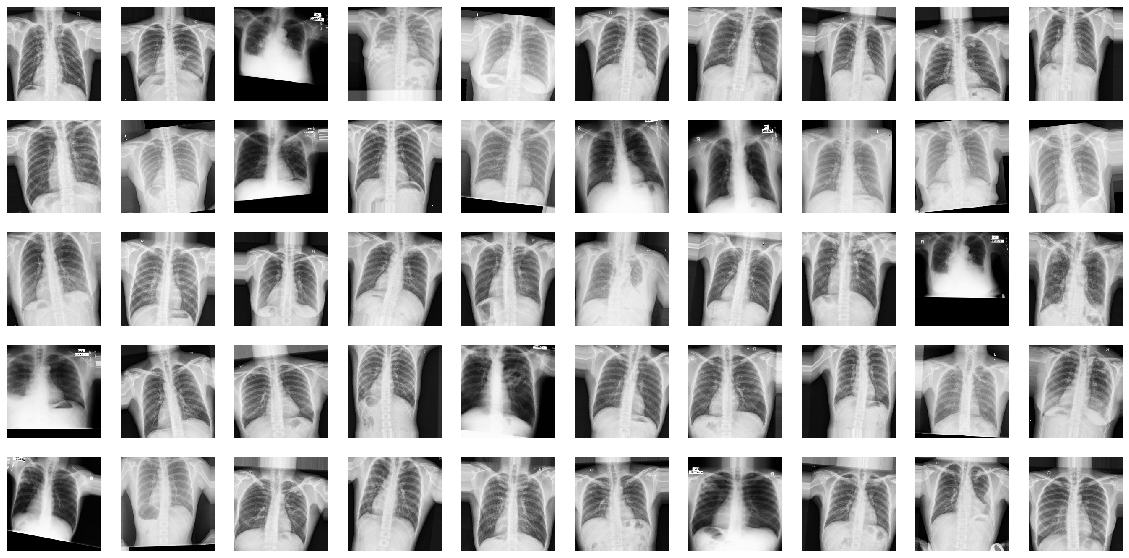

In [31]:
plots(imgs, titles=None) # titles=labels will display the image labels

# Create the VGG19 model

In [32]:
# Import the Vgg 19 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
# [3]= dimension of RGB
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
IMAGE_SIZE = [224, 224]
conv_base = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [33]:
# don't train existing weights
#freeze the weight layers from all the layers in the model
for layer in conv_base.layers:
    layer.trainable = False

In [34]:
from glob import glob
# useful for getting number of output classes
folders = glob('C:/Users/User/DEEP LEARNING/TB_directoriesVGG19_feature_extract(try)/train_dir/*')
folders

['C:/Users/User/DEEP LEARNING/TB_directoriesVGG19_feature_extract(try)/train_dir\\Normal',
 'C:/Users/User/DEEP LEARNING/TB_directoriesVGG19_feature_extract(try)/train_dir\\Tuberculosis']

In [35]:
# Source: https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

#kernel_size = (3,3)
#pool_size= (2,2)
#first_filters = 32
#second_filters = 64
#third_filters = 128
#dropout_conv = 0.3

dropout_dense = 0.3


model = Sequential()

model.add(conv_base)
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 26,447,682
Trainable params: 6,423,298
Non-trainable params: 20,024,384
_________________________________________________________________


Set the generator

In [36]:
#train_path = 'TB_directories(try)/train_dir'
#valid_path = 'TB_directories(try)/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10


train_steps = np.ceil(num_train_samples / train_batch_size) #680 / 10 =68 steps per epoch
val_steps = np.ceil(num_val_samples / val_batch_size) #120 / 10 = 12 steps per epoch

In [37]:
#read the dataset from the folder
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)

train_set = datagen.flow_from_directory('TB_directoriesVGG19_feature_extract(try)/train_dir',
                                        target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
                                        batch_size= 10,
                                        class_mode='categorical',
                                        follow_links=True)

val_set = datagen.flow_from_directory('TB_directoriesVGG19_feature_extract(try)/val_dir',
                                        target_size=(IMAGE_WIDTH,IMAGE_HEIGHT),
                                        batch_size= 10,
                                        class_mode='categorical',
                                        follow_links =True)

# Note: shuffle=False causes the test dataset to not be shuffled
test_set = datagen.flow_from_directory('TB_directoriesVGG19_feature_extract(try)/val_dir',
                                        target_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                        batch_size=10,
                                        class_mode='categorical',
                                        shuffle=False)

Found 3020 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


# Train the model

In [38]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', 
              metrics=['accuracy'])

In [39]:
filepath = "TB_model_100_epoch_VGG19_feature_extract.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]
#model.fit_generator
#model.fit_generator
history = model.fit(train_set, 
                    steps_per_epoch=train_steps, 
                    validation_data=val_set,
                    validation_steps=val_steps,
                    epochs=100, 
                    verbose=1,
                    callbacks=callbacks_list)

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 0.7350 - accuracy: 0.6588
Epoch 00001: val_accuracy improved from -inf to 0.81667, saving model to TB_model_100_epoch_VGG19_feature_extract.h5
68/68 [==============================] - 560s 8s/step - loss: 0.7350 - accuracy: 0.6588 - val_loss: 0.4384 - val_accuracy: 0.8167
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 0.5330 - accuracy: 0.7368
Epoch 00002: val_accuracy improved from 0.81667 to 0.87500, saving model to TB_model_100_epoch_VGG19_feature_extract.h5
68/68 [==============================] - 560s 8s/step - loss: 0.5330 - accuracy: 0.7368 - val_loss: 0.3528 - val_accuracy: 0.8750
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.5092 - accuracy: 0.7618
Epoch 00003: val_accuracy did not improve from 0.87500
68/68 [==============================] - 562s 8s/step - loss: 0.5092 - accuracy: 0.7618 - val_loss: 0.3566 - val_accuracy: 0.8583
Epoch 4/100
68/68 [==============

Epoch 28/100
68/68 [==============================] - ETA: 0s - loss: 0.3445 - accuracy: 0.8544
Epoch 00028: val_accuracy did not improve from 0.92500
68/68 [==============================] - 555s 8s/step - loss: 0.3445 - accuracy: 0.8544 - val_loss: 0.2657 - val_accuracy: 0.9083
Epoch 29/100
68/68 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.8706
Epoch 00029: val_accuracy did not improve from 0.92500
68/68 [==============================] - 554s 8s/step - loss: 0.3224 - accuracy: 0.8706 - val_loss: 0.2586 - val_accuracy: 0.9083
Epoch 30/100
68/68 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.8441
Epoch 00030: val_accuracy did not improve from 0.92500
68/68 [==============================] - 553s 8s/step - loss: 0.3507 - accuracy: 0.8441 - val_loss: 0.2648 - val_accuracy: 0.9250
Epoch 31/100
68/68 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8912
Epoch 00031: val_accuracy did not improve from 0.92500
68/68 

68/68 [==============================] - ETA: 0s - loss: 0.2356 - accuracy: 0.9279
Epoch 00086: val_accuracy did not improve from 0.92500
68/68 [==============================] - 529s 8s/step - loss: 0.2356 - accuracy: 0.9279 - val_loss: 0.2817 - val_accuracy: 0.8750
Epoch 87/100
68/68 [==============================] - ETA: 0s - loss: 0.2650 - accuracy: 0.9029
Epoch 00087: val_accuracy did not improve from 0.92500
68/68 [==============================] - 529s 8s/step - loss: 0.2650 - accuracy: 0.9029 - val_loss: 0.2551 - val_accuracy: 0.8833
Epoch 88/100
68/68 [==============================] - ETA: 0s - loss: 0.2709 - accuracy: 0.9147
Epoch 00088: val_accuracy did not improve from 0.92500
68/68 [==============================] - 793s 12s/step - loss: 0.2709 - accuracy: 0.9147 - val_loss: 0.2561 - val_accuracy: 0.8917
Epoch 89/100
68/68 [==============================] - ETA: 0s - loss: 0.2526 - accuracy: 0.9074 
Epoch 00089: val_accuracy did not improve from 0.92500
68/68 [==========

Plot the training curves

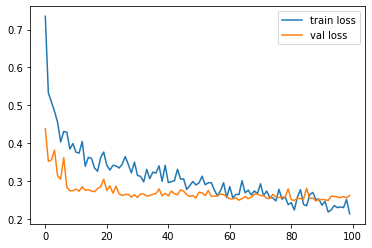

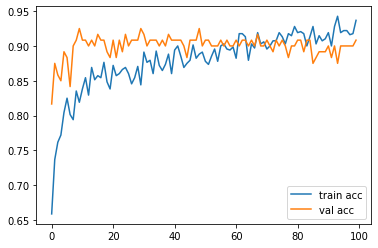

<Figure size 432x288 with 0 Axes>

In [40]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [41]:
#save the model
#save it as a h5 file

from tensorflow.keras.models import load_model

model.save('TB_vgg19model_100epoch_VGG19_feature_extract.h5')

# Evaluate the model using val_set

In [42]:
# get the metric names so we can use evaulate_generator
model.metrics_names

['loss', 'accuracy']

In [43]:
# Here the best epoch will be used.
#validate the model
model.load_weights('TB_vgg19model_100epoch_VGG19_feature_extract.h5')
val_loss, val_acc = \
model.evaluate(test_set, 
               steps=val_steps)

print('val_loss:', val_loss)
print('val_acc:', val_acc)

12/12 [==============================] - 74s 6s/step - loss: 0.2631 - accuracy: 0.9083
val_loss: 0.2631099820137024
val_acc: 0.9083333611488342


# Testing on Confusion Matrix

In [44]:
# Get the labels of the test images.

test_labels = test_set.classes

In [45]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [46]:
# Print the label associated with each class
test_set.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [47]:
# make a prediction
predictions = model.predict(test_set, steps=val_steps, verbose=1)

12/12 [==============================] - 92s 8s/step


In [48]:
predictions.shape

(120, 2)

In [49]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [50]:
test_labels.shape

(120,)

In [51]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [52]:
test_set.class_indices

{'Normal': 0, 'Tuberculosis': 1}

Confusion matrix, without normalization
[[60  1]
 [10 49]]


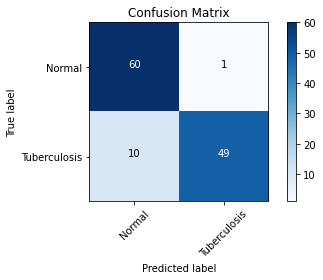

In [53]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['Normal', 'Tuberculosis']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

Create a Classification Report

In [54]:
# Get the filenames, labels and associated predictions

# This outputs the sequence in which the generator processed the test images
test_filenames = test_set.filenames

# Get the true labels
y_true = test_set.classes

# Get the predicted labels
y_pred = predictions.argmax(axis=1)

In [55]:
from sklearn.metrics import classification_report

# Generate a classification report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

              precision    recall  f1-score   support

      Normal       0.86      0.98      0.92        61
Tuberculosis       0.98      0.83      0.90        59

    accuracy                           0.91       120
   macro avg       0.92      0.91      0.91       120
weighted avg       0.92      0.91      0.91       120



# TB Prediction based on other dataset


In [59]:
#predict the model accuracy in real timme data
#give outside data to predict the model
from tensorflow.keras.models import load_model
from keras.preprocessing import image

model=load_model('TB_vgg19model_100epoch_VGG19_feature_extract.h5')

In [61]:
import numpy as np
from keras.preprocessing import image
# to predict outside data
TB_file='C:/Users/User/DEEP LEARNING/deep learning/base_directories/train_dir/Tuberculosis/_20_2839539.png'
TB_img=image.load_img(TB_file, target_size=(224,224))
TB_img=image.img_to_array(TB_img)
TB_img=np.expand_dims(TB_img,axis=0)
TB_img=TB_img/255

In [63]:
prediction_probabilities=model.predict(TB_img)

In [59]:
test_set.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [64]:
x = round(prediction_probabilities[0,0], 2)
y = round(prediction_probabilities[0,1], 2)
predict = np.array([x,y])
data=predict
if data[1] > 0.50: 
 print("I think its a TB")
            
else:
 print("looks like Normal")
            
#output prediction #to predict outside data
print(f"The Probability of the image is :{prediction_probabilities}")

I think its a TB
The Probability of the image is :[[0.06154498 0.938455  ]]


In [60]:
#output prediction #to predict outside data
print(f"Probability the image is Normal is :{prediction_probabilities}")

Probability the image is Normal is :[[0.06154498 0.938455  ]]


In [62]:
from tensorflow.keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
import numpy as np

model=load_model('TB_vgg19model_100epoch_VGG19_feature_extract.h5')
img=image.load_img('C:/Users/User/DEEP LEARNING/deep learning/base_directories/train_dir/Tuberculosis/_20_2839539.png', target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)
print(classes)

[[2.7001718e-25 1.0000000e+00]]


In [63]:
#!pip install tensorflowjs
# create a directory to store the model files
import os
os.mkdir('tfjs_dir(VGG19_feature-extract)')

# convert to Tensorflow.js
import tensorflowjs as tfjs

# Error
# AttributeError: module 'tensorflow.python.data.ops.dataset_ops' 
    # has no attribute 'UnaryDataset'

tfjs.converters.save_keras_model(model, 'tfjs_dir(VGG19_feature-extract)')

C:\Users\User\miniconda3\lib\site-packages\tensorflowjs\converters\keras_h5_conversion.py:123: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [64]:
# view the files that make up the tensorflow.js model
os.listdir('tfjs_dir(VGG19_feature-extract)')

['group1-shard10of26.bin',
 'group1-shard11of26.bin',
 'group1-shard12of26.bin',
 'group1-shard13of26.bin',
 'group1-shard14of26.bin',
 'group1-shard15of26.bin',
 'group1-shard16of26.bin',
 'group1-shard17of26.bin',
 'group1-shard18of26.bin',
 'group1-shard19of26.bin',
 'group1-shard1of26.bin',
 'group1-shard20of26.bin',
 'group1-shard21of26.bin',
 'group1-shard22of26.bin',
 'group1-shard23of26.bin',
 'group1-shard24of26.bin',
 'group1-shard25of26.bin',
 'group1-shard26of26.bin',
 'group1-shard2of26.bin',
 'group1-shard3of26.bin',
 'group1-shard4of26.bin',
 'group1-shard5of26.bin',
 'group1-shard6of26.bin',
 'group1-shard7of26.bin',
 'group1-shard8of26.bin',
 'group1-shard9of26.bin',
 'model.json']